## Google earth - Create account 

In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
# libraries to install 
!pip install earthengine-api --upgrade

Requirement already up-to-date: earthengine-api in /usr/local/lib/python3.7/dist-packages (0.1.254)


In [3]:
from google.colab import drive ## to mount google drive so that files can be automatically saved there - Follow the instructions after running this command
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!pip install pyproj

     |████████████████████████████████| 6.5MB 6.6MB/s 


In [5]:
!pip install rasterio

     |████████████████████████████████| 19.1MB 1.3MB/s 


In [6]:
!earthengine authenticate

Instructions for updating:
non-resource variables are not supported in the long term
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=lTkrQkmfgYAMI3pOAjgJvy0J_1uJ3uzC1at7cSWLhBQ&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g5CDFZjmHsutapqjBuYW3iUahs7i7pAWs1B7bA03uuNdaXb_PXkyx0

Successfully saved authorization token.


In [7]:
!pip install -U -q folium
!pip install -U -q git+https://github.com/mccarthyryanc/folium_gee.git

     |████████████████████████████████| 102kB 4.9MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.12.1 which is incompatible.


In [11]:
import time

import ee
import folium
import foliumgee
import json
import os
from functools import partial
ee.Initialize()

import pyproj
from shapely.geometry import Point, mapping
from shapely.ops import transform
from tqdm import tqdm
from shapely.geometry import shape


start_date = '2017-01-01'
end_date = '2017-12-31'
def collection(name):
    """
    Creates an ee.ImageCollection stack or sequence of images
    for aoi between the desired start and end dates.

    Args:
        :param name: str
            name of image collection
    Returns:
        :returns iee.ImageCollection:
            an ImageCollection stack or sequence of images
    """
    return (ee.ImageCollection(name)
            .filterBounds(gg)
            .filterDate(start_date, end_date))

def rename_l8(image):
    """
    Args:
        :param image: ee.Image
            landsat8 image

    Returns:
        :returns:
            ee.Image with bands rescaled
    """
    newnames = ['AEROS', 'BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2',
                'TEMP1', 'TEMP2', 'sr_aerosol', 'pixel_qa', 'radsat_qa']
    return image.rename(newnames)

def rescale_l8(image):
    """
    Args:
        :param image: ee.Image
            landsat8 image
    Returns:
        :returns scaled:
            ee.Image with bands rescaled
    """
    opt = image.select(['AEROS', 'BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2'])
    therm = image.select(['TEMP1', 'TEMP2'])
    masks = image.select(['sr_aerosol', 'pixel_qa', 'radsat_qa'])

    opt = opt.multiply(0.0001)
    therm = therm.multiply(0.1)

    scaled = ee.Image.cat([opt, therm, masks]).copyProperties(image)
    # system properties are not copied
    scaled = scaled.set('system:time_start', image.get('system:time_start'))
    return scaled

def decode_qamask(image):
    """
    Args:
        :param image: ee.Image
            Landsat satellite image containing 'pixel_qa' band

    Returns:
        :returns masks: ee.Image
            contains 5 bands of masks
            Pixel QA Bit Flags
            Bit  Attribute
            0    Fill
            1    Clear
            2    Water
            3    Cloud Shadow
            4    Snow
            5    Cloud
    """
    qa = image.select('pixel_qa')
    clear = qa.bitwiseAnd(2).neq(0)  # 0 = not clear, 1 = clear
    clear = clear.updateMask(clear).rename(['pxqa_clear'])

    water = qa.bitwiseAnd(4).neq(0)  # 0 = not water, 1 = water
    water = water.updateMask(water).rename(['pxqa_water'])

    cloud_shadow = qa.bitwiseAnd(8).eq(0)  # 0 = shadow, 1 = not shadow
    cloud_shadow = cloud_shadow.updateMask(cloud_shadow).rename(['pxqa_cloudshadow'])

    snow = qa.bitwiseAnd(16).eq(0)  # 0 = snow, 1 = not snow
    snow = snow.updateMask(snow).rename(['pxqa_snow'])

    cloud = qa.bitwiseAnd(32).eq(0)  # 0 = cloud, 1 = not cloud
    cloud = cloud.updateMask(cloud).rename(['pxqa_cloud'])

    masks = ee.Image.cat([clear, water, cloud_shadow, snow, cloud])
    return masks

def mask_qaclear( image):
    """
    Args:
        :param image: ee.Image
            Landsat satellite image

    Returns:
        :returns masked_image: ee.Image
            input image with cloud-shadow, snow, cloud, and unclear
            pixels masked out
    """
    qam = decode_qamask(image)
    cloudshadow_mask = qam.select('pxqa_cloudshadow')
    snow_mask = qam.select('pxqa_snow')
    cloud_mask = qam.select('pxqa_cloud')
    masked_image = (image
                    .updateMask(cloudshadow_mask)
                    .updateMask(snow_mask)
                    .updateMask(cloud_mask))
    return masked_image


def reproject_geom(geom, src_epsg, dst_epsg):
    """Reproject a shapely geometry given a source EPSG and a
    target EPSG.
    """
    src_proj = pyproj.Proj(init='epsg:{}'.format(src_epsg))
    dst_proj = pyproj.Proj(init='epsg:{}'.format(dst_epsg))
    reproj = partial(pyproj.transform, src_proj, dst_proj)
    return transform(reproj, geom)


def buffer_extent(lat, lon, dst_epsg, buffer_size):
    """Generate a buffer around a location and returns
    the geometry corresponding to its spatial envelope.
    """
    center = reproject_geom(
        Point(lon, lat), src_epsg=4326, dst_epsg=dst_epsg)
    buffer = center.buffer(buffer_size)
    return buffer.exterior.envelope


def geojson_crs(epsg):
    """Generate a GeoJSON CRS member from an EPSG code."""
    epsg = int(epsg)
    if epsg == 4326:
        coordinate_order = [1, 0]
    else:
        coordinate_order = [0, 1]
    return {
        'type': 'EPSG',
        'properties': {'code': epsg, 'coordinate_order': coordinate_order}}


def as_geojson(geom, epsg=None):
    """Get a GeoJSON-like dictionnary of a single shapely geometry."""
    geojson = {'type': 'Feature', 'geometry': mapping(geom)}
    if epsg:
        geojson.update(crs=geojson_crs(epsg))
    return geojson


def write(geom, output_f):
    """Write a GeoJSON-like dictionnary to disk."""
    geojson = json.dumps(geom, indent=True)
    os.makedirs(os.path.dirname(output_f), exist_ok=True)
    with open(output_f, 'w') as f:
        f.write(geojson)
    return


In [12]:
img = ee.ImageCollection('USDA/NASS/CDL').select('cropland').median()

In [13]:
# Define a method for displaying Earth Engine image tiles on a folium map.
def add_ee_layer(self, ee_object, vis_params, name):
    
    try:    
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):    
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):    
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
    
    except:
        print("Could not display {}".format(name))
    
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [14]:
cropLandcover = ee.ImageCollection('USDA/NASS/CDL').filter(ee.Filter.date('2018-01-01', '2019-12-31')).first().select('cropland')
# Create a folium basemap into which EE layers above will be added
myMap = folium.Map(location=[40.71,-100.55], zoom_start=5)

foliumgee.layer(myMap, cropLandcover)

# Add a layer control widget to the map
myMap.add_ee_layer(cropLandcover, {}, 'Crop Landcover')

folium.LayerControl().add_to(myMap)

# Show the map!
myMap

In [15]:
lat = 40.71
lon = -100.55

In [16]:
extent = buffer_extent(lat, lon, 3857 , buffer_size=5000) #1.6594, 28.0339
extent = as_geojson(extent,3857)
aoi = reproject_geom(shape(extent['geometry']), 3857, 4326)
xmin, ymin, xmax, ymax = [round(coord, 3) for coord in aoi.bounds]

bbox = [xmin, ymin, xmax, ymax]
gg = ee.Geometry.Rectangle(bbox)

In [17]:
geov = gg.getInfo()['coordinates']
task_config = {
            'description': 'geov',
            'scale': 30,
            'folder': 'images_satellite','fileNamePrefix':'geov3',
            'region':  geov 
        }


cropimg = ee.ImageCollection('USDA/NASS/CDL').filter(ee.Filter.date('2018-01-01', '2019-12-31')).first().select('cropland')


In [18]:
task = ee.batch.Export.image.toDrive(image=cropimg,**task_config)
task.start()

while task.active() == True:
  pass
print("completed")

completed


In [19]:
import rasterio as rio
from rasterio.plot import show
import matplotlib.pylab as plt
rr = "/content/gdrive/MyDrive/images_satellite/geov3.tif"
scene = rio.open(rr)

In [20]:
scene.read().shape

(1, 266, 264)

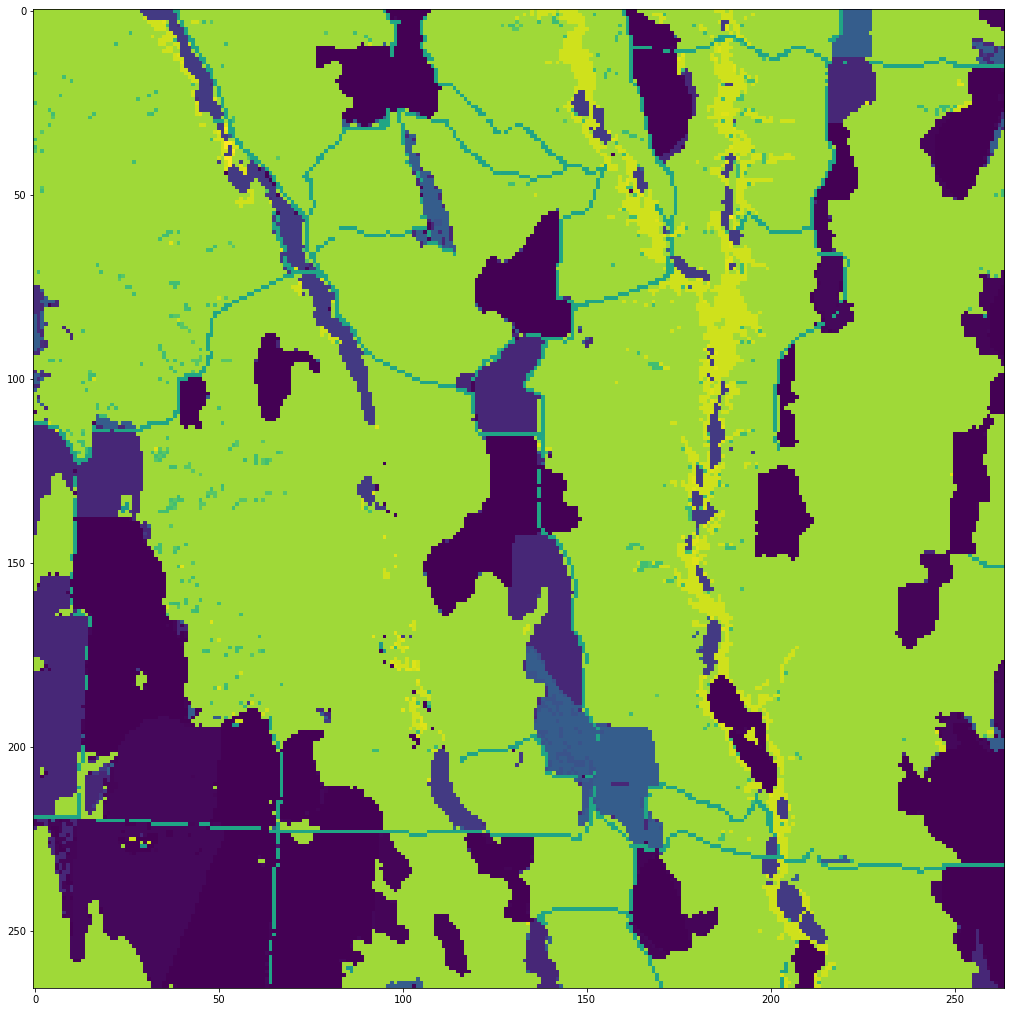

In [21]:
fig, ax = plt.subplots(1, figsize=(18,18))
show(scene.read(1))
plt.show()